In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ROC AUC 

ROC-AUC строится, когда сортируем результаты классификатора по вероятности, по ним строим кривую и считаем площадь. Тут мы смотрим, что будет, если мы будем "классифицировать" по одной фиче. Сортируем фичу и соответствующие ей y по значению фичи. Т.е говорим: "Давайте предсказывать y по одной фиче". И порогоровое условие - это место, где говорим:  "если фича больше этого порога, то класс - 1". Считаем для каждой фичи auc, где вместо вероятности берем само значение фичи, и потом для трех лучших фич по auc рисуем roc-curve

In [2]:
def ROC_AUC(y, prob):
    res = sorted(list(zip(prob, y)), reverse=True)
    step_x = 1/np.where(y != 1)[0].shape[0]
    step_y = 1/np.where(y == 1)[0].shape[0]
    points_x = [0]
    points_y = [0]
    last_x = 0
    last_y = 0
    auc = 0
    for prob, sample_y in res:
        if sample_y == 1:
            points_x.append(last_x)
            last_y += step_y
            points_y.append(last_y)
        else:
            points_y.append(last_y)
            last_x += step_x
            points_x.append(last_x)
            auc += step_x * last_y
    return auc, points_x, points_y

# Spam

In [3]:
df = pd.read_csv("spam.csv")
X = df[df.columns.difference(['label'])]
y = df.label.values
aucs=[]
for column in X.columns:
    auc, points_x, points_y = ROC_AUC(y, X[column].values)
    aucs.append(auc)
ind=np.array(aucs).argsort()
print("feature:", X.columns[ind[ind.shape[0]-1]], "auc:", aucs[ind[ind.shape[0]-1]])
print("feature:", X.columns[ind[ind.shape[0]-2]], "auc:", aucs[ind[ind.shape[0]-2]])
print("feature:", X.columns[ind[ind.shape[0]-3]], "auc:", aucs[ind[ind.shape[0]-3]])

feature: word_freq_3d auc: 0.9971808103597595
feature: word_freq_font auc: 0.9922898625501807
feature: word_freq_remove auc: 0.9879969786200758


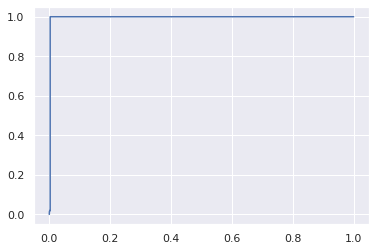

In [4]:
feature = 'word_freq_3d'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

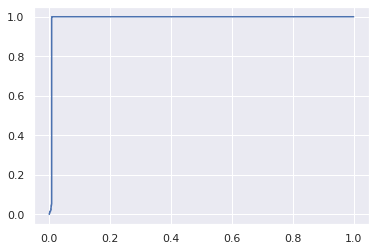

In [5]:
feature = 'word_freq_font'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

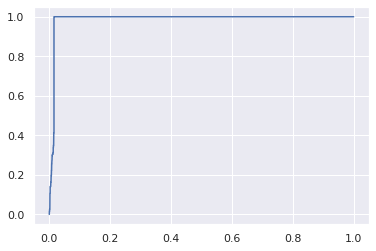

In [6]:
feature = 'word_freq_remove'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

# Cancer

In [7]:
df = pd.read_csv("cancer.csv")
X = df[df.columns.difference(['label'])]
y = df.label.values
for i in range(y.shape[0]):
    if(y[i]=='M'):
        y[i]=1
    else:
        y[i]=0
aucs=[]
for column in X.columns:
    auc, points_x, points_y = ROC_AUC(y, X[column].values)
    aucs.append(auc)
ind=np.array(aucs).argsort()
print("feature:", X.columns[ind[ind.shape[0]-1]], "auc:", aucs[ind[ind.shape[0]-1]])
print("feature:", X.columns[ind[ind.shape[0]-2]], "auc:", aucs[ind[ind.shape[0]-2]])
print("feature:", X.columns[ind[ind.shape[0]-3]], "auc:", aucs[ind[ind.shape[0]-3]])

feature: 23 auc: 0.9755562602399477
feature: 21 auc: 0.9705618096295139
feature: 24 auc: 0.9698615295174705


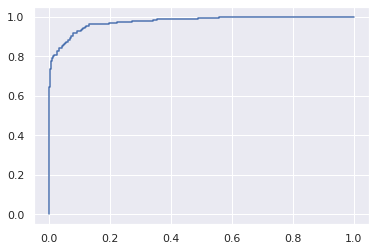

In [8]:
feature = '23'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

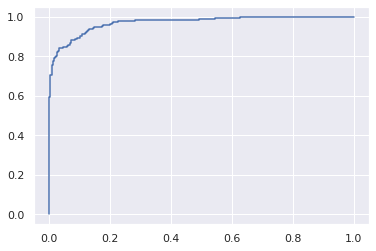

In [9]:
feature = '21'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

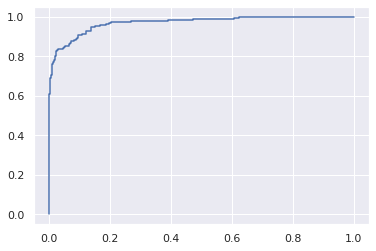

In [10]:
feature = '24'
auc, points_x, points_y = ROC_AUC(y, X[feature].values)
plt.plot(points_x, points_y)

# Split the data

In [11]:
#Spam
df = pd.read_csv('spam.csv')
train = df.sample(frac = 0.8, random_state = 200)
test = df.drop(train.index)

In [12]:
print("Check proportions")
print("Train 1st class share:", train.label.values[train.label.values == 1].shape[0] / train.label.values.shape[0])
print("Test 1st class share:", test.label.values[test.label.values == 1].shape[0] / test.label.values.shape[0])


Check proportions
Train 1st class share: 0.39663135017658246
Test 1st class share: 0.38369565217391305


In [13]:
#Cancer
df_1 = pd.read_csv('cancer.csv')
for i in range(df_1.label.values.shape[0]):
    if(df_1.label.values[i]=='M'):
        df_1.label.values[i]=1
    else:
        df_1.label.values[i]=0
train_1 = df_1.sample(frac = 0.8, random_state=45)
test_1 = df_1.drop(train_1.index)

In [14]:
print("Check proportions")
print("Train 1st class share:", train_1.label.values[train_1.label.values == 1].shape[0] / train_1.label.values.shape[0])
print("Test 1st class share:", test_1.label.values[test_1.label.values == 1].shape[0] / test_1.label.values.shape[0])


Check proportions
Train 1st class share: 0.37362637362637363
Test 1st class share: 0.3684210526315789


# Decision tree

In [15]:
def calc_entropy(table):
    target = table.keys()[-1]
    entropy = 0
    values = table[target].unique() 
    for value in values:
        frac = table[target].value_counts()[value]/len(table[target])
        if frac == 0:
            return 0
        entropy += -frac*np.log2(frac)
    return(entropy) # returns entropy of whole dataset

In [16]:
def impurity(table, feature,mode, data):
    target = table.keys()[-1]
    variables = table[feature].unique() 
    target_variables = table[target].unique() 
    info = 0
    if mode is 'entropy':
        for v in variables:
            entropy = 0
            for target_v in target_variables:
                n = len(table[feature][table[feature] == v][table[target] == target_v])
                d = len(table[feature][table[feature] == v])
                frac1 = n/(d + np.finfo(float).eps) 
                if frac1 == 0:
                    entropy += 0
                else:
                    entropy += -frac1 * np.log2(frac1)
            frac2 = d/len(table)
            info += -frac2 * entropy
        return abs(info)
    elif mode is 'gini':
        num_of_ones = table['label'].tolist().count(1)
        p = num_of_ones/float(len(data.index))
        gini_index = 2*p*(1-p)
        return gini_index
    elif mode is 'misclassification':
        num_of_ones = table['label'].tolist().count(1)
        p = num_of_ones/float(len(data.index))
        missclasification = min(p,1-p)
        return missclasification

In [17]:
def winner_feature(table, feature_list,mode, data):
    info_gain = []
    if len(feature_list) == 1:
        return feature_list[0]
    for feature in feature_list:
        if mode is 'entropy':
            info_gain.append(calc_entropy(table) - impurity(table, feature, 'entropy', data))
        elif mode is 'gini':
            info_gain.append(calc_entropy(table) - impurity(table, feature, 'gini', data))
        elif mode is 'misclassification':
            info_gain.append(calc_entropy(table) - impurity(table, feature, 'misclassification', data))
    return feature_list[np.argmax(info_gain)]

In [18]:
def build_tree(table, prev_table, feature_list, mode, data, tree = None):
    if len(table['label'].unique()) <= 1:
        return {'leaf' : table['label'].unique()[0]}
    elif len(table) == 0:
        return {'leaf': np.unique(table['label'])[np.argmax(np.unique(table['label'], return_counts = True)[1])]}
    elif len(feature_list) == 0:
        return {'leaf': np.unique(table['label'])[np.argmax(np.unique(table['label'], return_counts = True)[1])]}
    node = winner_feature(table, feature_list, mode, data)
    feature_list.remove(node)
    if tree is None:
        tree = {}
        tree[node] = {}
        tree['default'] = np.unique(table['label'])[(np.argmax(np.unique(table['label'], return_counts = True)[1]))]
    for v in table[node].unique():
        mod_table = table.where(table[node] == v).dropna()
        tree[node][v] = build_tree(mod_table, table, feature_list[:], mode, data)
    return tree

In [19]:
def pred(query, tree):
    try:
        if list(tree.keys())[0] == 'leaf':
            return tree['leaf']
        if list(tree.keys())[0] is 'default':
            val = query[list(tree.keys())[1]]
            next = list(tree.keys())[1]
        else:
            val = query[list(tree.keys())[0]]
            next = list(tree.keys())[0]
        return pred(query, tree[next][val])
    except:
        return 0
predicted = []
def prediction(tree, data):
    for index, row in data.iterrows():
        predicted.append(pred(row, tree))

In [20]:
def calc_metrics(predictions, actual):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == predictions[i] and actual[i] == 1:
            tp += 1
        elif actual[i] == predictions[i] and actual[i] == 0:
            tn += 1
        elif actual[i] != predictions[i] and actual[i] == 0:
            fp += 1
        else:
            fn += 1
    accuracy = (tn + tp)/(tn + tp + fp + fn)
    if tp + fp == 0:
        return accuracy
    return accuracy
    print('Accuracy - ', accuracy)

In [21]:
def prediction_util(query, tree, current_depth, max_depth):
    try:
        if list(tree.keys())[0] == 'leaf':
            new_prediction_dict[max_depth].append(tree['leaf'])
            return
        if list(tree.keys())[0] == 'default':
            val = query[list(tree.keys())[1]]
            next = list(tree.keys())[1]
        else:
            val = query[list(tree.keys())[0]]
            next = list(tree.keys())[0]
        if(current_depth == max_depth):
            new_prediction_dict[current_depth].append(tree['default'])
            return
        prediction_util(query, tree[next][val], current_depth + 1, max_depth)
    except:
        new_prediction_dict[max_depth].append(0)

def new_prediction(tree, data, max_depth):
    for index, row in data.iterrows():
        prediction_util(row, tree, 0, max_depth)

# Spam

Entropy

1 0.616304347826087
2 0.683695652173913
3 0.6989130434782609
4 0.6989130434782609
5 0.6989130434782609
6 0.6989130434782609
7 0.6989130434782609
8 0.6989130434782609
9 0.6989130434782609
10 0.6967391304347826
Best number of levels 9


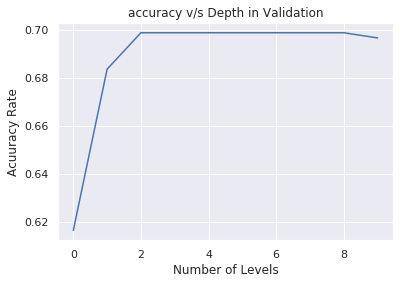

In [22]:
X = train[train.columns.difference(['label'])]
tree = build_tree(train, train, list(X.columns), 'entropy', df)
# pprint.pprint(tree)
predicted = []
prediction(tree, test)
target = test['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test, i)
accuracy = []
target = test['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()

Gini

1 0.616304347826087
2 0.683695652173913
3 0.7032608695652174
4 0.7032608695652174
5 0.7032608695652174
6 0.7032608695652174
7 0.7032608695652174
8 0.7032608695652174
9 0.7032608695652174
10 0.7032608695652174
Best number of levels 10


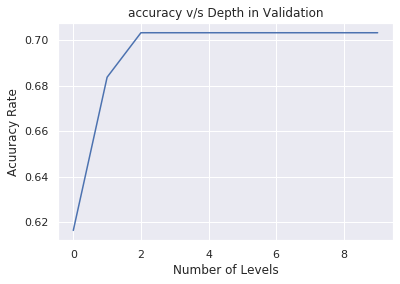

In [23]:
X = train[train.columns.difference(['label'])]
tree = build_tree(train, train, list(X.columns), 'gini', df)
# pprint.pprint(tree)
predicted = []
prediction(tree, test)
target = test['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test, i)
accuracy = []
target = test['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()

Misclassification error

1 0.616304347826087
2 0.683695652173913
3 0.7032608695652174
4 0.7032608695652174
5 0.7032608695652174
6 0.7032608695652174
7 0.7032608695652174
8 0.7032608695652174
9 0.7032608695652174
10 0.7032608695652174
Best number of levels 10


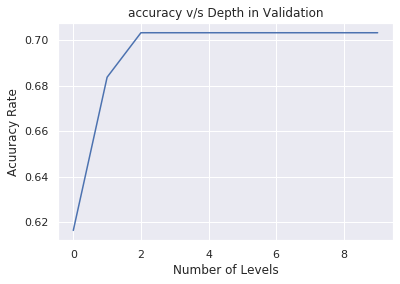

In [24]:
X = train[train.columns.difference(['label'])]
tree = build_tree(train, train, list(X.columns), 'misclassification', df)
# pprint.pprint(tree)
predicted = []
prediction(tree, test)
target = test['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test, i)
accuracy = []
target = test['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()

# Cancer

Entropy

In [ ]:
X = train_1[train_1.columns.difference(['label'])]
tree = build_tree(train_1, train_1, list(X.columns), 'entropy', df_1)
# pprint.pprint(tree)
predicted = []
prediction(tree, test_1)
target = test_1['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test_1, i)
accuracy = []
target = test_1['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)   
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()

Gini

In [ ]:
X = train_1[train_1.columns.difference(['label'])]
tree = build_tree(train_1, train_1, list(X.columns), 'gini', df_1)
# pprint.pprint(tree)
predicted = []
prediction(tree, test_1)
target = test_1['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test_1, i)
accuracy = []
target = test_1['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)   
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()

Misclassification error

In [ ]:
X = train_1[train_1.columns.difference(['label'])]
tree = build_tree(train_1, train_1, list(X.columns), 'misclassification', df_1)
# pprint.pprint(tree)
predicted = []
prediction(tree, test_1)
target = test_1['label'].tolist()
calc_metrics(predicted, target)
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, test_1, i)
accuracy = []
target = test_1['label'].tolist()
for i in range(10):
    print(i+1, calc_metrics(new_prediction_dict[i], target) )
    accuracy.append(calc_metrics(new_prediction_dict[i], target))
print('Best number of levels', np.array(accuracy).argsort()[np.array(accuracy).argsort().shape[0]-1]+1)   
plt.plot([i for i in range(0, 10)], accuracy)
plt.title('accuracy v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Acuuracy Rate')
plt.show()